<table style="width: 100%; border-style: none;">
<tr style="border-style: none">
<td style="border-style: none; width: 1%; font-size: 16px">Institut f&uuml;r Theoretische Physik<br /> Universit&auml;t zu K&ouml;ln</td>
<td style="border-style: none; width: 1%; font-size: 16px">&nbsp;</td>
<td style="border-style: none; width: 1%; text-align: right; font-size: 16px">Prof. Dr. Simon Trebst<br />Peter Br&ouml;cker</td>
</tr>
</table>
<hr>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">Computerphysik</h1>
<h1 style="font-weight:bold; text-align: center; margin: 0px; padding:0px;">&Uuml;bungsblatt 11</h1>
<hr>
<h3 style="font-weight:bold; text-align: center; margin: 0px; padding:0px; margin-bottom: 20px;">Sommersemester 2016</h3>

<p>**Website:** [http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml](http://www.thp.uni-koeln.de/trebst/Lectures/2016-CompPhys.shtml)</p>

<p>**Abgabe**: Montag, 4. Juli, 2016 vor der Vorlesung</p>

<p>**Name**: <font color="red">Bitte geben Sie ihren Namen an</font></p>

<p>**Matrikelnummer**: <font color="red">Bitte geben Sie ihre Matrikelnummer an</font></p><br />


<table style="border-style: none; width: 100%; margin-top: 20px; padding: 0px;"
><tr style="border-style: none; margin: 0px; padding: 0px;">
<td style="border-style: none; width: 80%; margin: 0px; padding: 0px; font-size: 20px; font-weight: bold">Der Geist in der Matrix</td>
<td style="border-style: none; width: 20%; margin: 0px; padding: 0px; text-align: right">(6 Punkte)</td></tr></table>

### Teil A
Der erste Schritt auf dem Weg zum Verständnis des Lanczos Algorithmus ist die **Power-Methode**. Mit ihrer Hilfe bestimmen wir den betragsgrößten Eigenwert und den zugehörigen Eigenvektor einer Matrix durch wiederholtes Anwenden ebendieser auf einen initialen Startvektor. Die Matrix sei $H$ und der Startvektor $b_0$. Diesen Vektor iterieren wir mithilfe der Relation

\begin{equation}
b_{k + 1} = \dfrac{H b_k}{|H b_k|}
\end{equation}

In dieser Aufgabe starten wir mit dem Vektor $\left(1, 1, 1, 1\right)^T$ und suchen nach dem größten Eigenwert der Matrix
\begin{equation}
H = 
\begin{pmatrix}
1 && 1 && 1 && 1 \\
1.1 && 1.2 && 1.3 && 1.4 \\
1.1 && 1.4 && 1.9  && 1.16 \\
1.1 && 1.8 && 1.27 && 1.64
\end{pmatrix}
\end{equation}

(1) Berechnen Sie die Eigenwerte und Eigenvektoren der Matrix mittels der Julia Funktion *eig*.

(2) Iterieren Sie den Startvektor gemäß der oben angegebenen Vorschrift und plotten Sie die Norm des Differenzvektors als Funktion des Iterationsschritts.

In [1]:
function sort_eigvals(tuple)
    vals, vecs = tuple
    permutation = sortperm(vals) # get the sorting permutation = order of sorted indexes
    vals = vals[permutation]
    vecs = vecs[:, permutation]
    
    return (vals, vecs)
end

sort_eigvals (generic function with 1 method)

In [86]:
N = 10
b = [1, 1, 1, 1]
H = [1 1 1 1 ; 1.1 1.2 1.3 1.4 ; 1.1 1.4 1.9 1.16 ; 1.1 1.8 1.27 1.64];
eigval0, eigvec0 = sort_eigvals(eig(H))

([-0.21728722101372155,0.1962454128899752,0.6127607046548779,5.148281103468877],
4x4 Array{Float64,2}:
 -0.0498191   0.8594      0.0942349  0.384649
 -0.748967    0.0136059   0.161453   0.486655
  0.171532   -0.270966   -0.786527   0.542354
  0.638078   -0.433386    0.588582   0.566626)

In [2]:
norm0 = norm(eigval0)
norms = [norm0 - norm(b)]
for i in 1:N
    b2, b = b, H*b/norm(H*b)
    push!(norms, norm(b2-b))
end

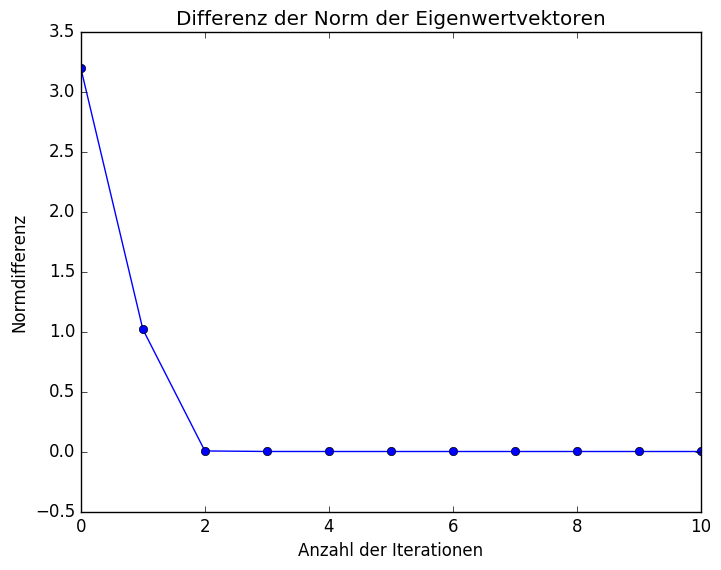

In [3]:
using PyPlot

title("Differenz der Norm der Eigenwertvektoren")
xlabel("Anzahl der Iterationen")
ylabel("Normdifferenz")
plot(collect(0:N), norms, marker="o")
ylim(-0.5,3.5)
;

### Teil B: Lanczos

Wie Sie in der Vorlesung gesehen haben, funktioniert der **Lanczos**-Algorithmus sehr ähnlich, erlaubt aber die Bestimmung mehrerer Eigenwerte und Eigenvektoren. Insbesondere in der Vielteilchenphysik ist das Lanczos-Verfahren ein absolutes Standardverfahren, um exakte Informationen über ein Modell zu erhalten. 

In dieser Aufgabe betrachten wir eine Kette aus sogenannten *hard core bosons*, die wir mit einem Hamiltonian beschreiben, der Ihnen vielleicht vom harmonischen Oszillator ein wenig vertraut erscheinen mag:

\begin{equation}
H = -t\sum\limits_{\langle i, j \rangle}\left( a_i^\dagger a_j^{\phantom\dagger} + h.c.\right) + V\sum\limits_{\langle i, j \rangle}n_i n_j
\end{equation}

Die Summen laufen über benachbarte Gitterplätze $i$ und $j$, was typischerweise durch die Klammer $\langle \dots\rangle$ angezeigt wird. In der ersten Summe werden nun Teilchen auf Platz $j$ durch den Operator $a_j^{\phantom\dagger}$ vernichtet und am Platz $i$ mit $a_i^\dagger$ erzeugt. Er beschreibt also einen Hüpfvorgang und steht für die kinetische Energie des Systems. Mit dem negativen Vorfaktor $-t$ erkennen wir, dass die Energie niedriger ist, je mobiler die Teilchen sind. In der zweiten Summe werden nun die Teilchenzahlen $n_i$ auf benachbarten Gitterplätzen betrachtet, weshalb dieser Teil die potentielle Energie des Systems darstellt. 

Eine Besonderheit, die das Aufstellen des Hamiltonians erleichtert ist, dass hard core bosonen zwar bosonischen Kommutationsregeln unterliegen, es aber dennoch jeder Zustand nur durch maximal ein Boson besetzt werden darf, sie also einer Art Pauli-Prinzip unterliegen. Das Austellen der Matrix geschieht in dem untenstehenden, ausführlich kommentierten Code.

In [4]:
# Anzahl der Plaetze auf der Kette
N = 8 
# Anzahl der Teilchen
p = Int(N / 2) 

# Groesse des Hilbertraum, verteile p Teilchen auf N Plaetze
n_states = binomial(N, p)
# Array der die Zustaende speichert
states = zeros(Int8, N, n_states)
# Zaehler fuer Zustand
idx = [0]

t = -1. # Hoppingstaerke ~ kinetische Energie
V = -1. # Wechselwirkung ~ potentielle Energie

# Funktion wird rekursiv aufgerufen
function fill(state, pos, N, p, idx, states)
    # Abbruch wenn Gitterplatz ausserhalb der Kette gefuellt werden soll
    if pos > N
        # stimmt die Teilchenzahl?
        if sum(state) == p
            #speichere Zustand und erhoehe Zaehler
            idx[1] += 1
            states[:, idx[1]] = state
        end
        return
    end
        
    # lasse Position pos + 1 frei
    fill(copy(state), pos + 1, N, p, idx, states)
    # besetze Position pos + 1
    state[pos] = 1
    fill(copy(state), pos + 1, N, p, idx, states)
end

# erzeuge einen Referenzzustand
state = zeros(Int, N)
# fuelle Zustandsmatrix
fill(copy(state), 1, N, p, idx, states)

# der Hamiltonian ist eine duenn besetzte = sparse Matrix
H = spzeros(n_states, n_states)

# iteriere ueber alle Zustandskombinationen
for k in 1:n_states
    for b in 1:n_states
        
        # Wende Hamiltonian an
        for i in 1:N - 1
            ket = copy(states[:, k])
            bra = copy(states[:, b])
            
            # huepfen nur, wenn Zielplatz frei und Ausgangsplatz frei
            if (ket[i] == 0 && ket[i + 1] == 1) || (ket[i] == 1 && ket[i + 1] == 0)
                ket[i] = mod(ket[i] + 1, 2)
                ket[i+1] = mod(ket[i] + 1, 2)
                
                # Sind bra und ket gleich? ^= Skalarprodukt
                if maximum(abs(ket - bra)) == 0
                    H[b, k] += t
                    H[k, b] += t
                end
            end
            
            # Wechselwirkung, wenn beide Plaetze besetzt
            if ket[i] == 1 && ket[i + 1] == 1
                # Sind bra und ket gleich? ^= Skalarprodukt
                if maximum(abs(ket - bra)) == 0
                    H[b, k] += V
                    H[k, b] += V
                end
            end
        end
    end
end

Diagonlisieren Sie mithilfe des Lanczos-Algorithmus diese Matrix iterativ mit 300 Iterationsschritten. Speichern Sie während des Iterationsvorgangs die ersten zehn Eigenwerte ab und speichern diese ab. Beachten Sie, dass der j-te Eigenwert erst ab dem j-ten Iterationsschritt zur Verfügung steht. Plotten Sie dann den Verlauf dieser Eigenwerte als Funktion des Iterationsschritts. Beschreiben Sie das Konvergenzverhalten. Konvergieren alle gleichzeitig? Ist das Ergebnis für alle Eigenwerte stabil?

In [105]:
# initialize values
alphas = [0.0] # first value not needed, but it defines an Array{Float}
betas  = [0.0] # first value
v_prev = zeros(size(H, 1))
v_j    = rand(size(H, 1))

# iterate
for j in 1:300
    omega = H*v_j - betas[j]*v_prev
    push!(alphas, dot(conj(v_j), omega)) # in julia the product is an array, so it must be appended instead of being pushed
    omega = omega - alphas[j]*v_j
    push!(betas, norm(omega))
    v_prev, v_j = v_j, omega/betas[j+1]

end

sym3diag = SymTridiagonal(alphas[2:end], betas[2:end])
eigv     = eigvals(sym3diag[1:10, 1:10])

10-element Array{Float64,1}:
 -872.035 
 -367.981 
 -146.358 
  -53.5977
  -14.789 
   13.9894
   40.9967
  100.964 
  261.612 
  740.962 

**Hinweis**

Um die Berechnung der Eigenwerte zu beschleunigen, können Sie in Ihrem Algorithmus den Typ *SymTridiagonal* verwenden, der dann von Julia optimiert verarbeitet wird. Als Paramter übergeben Sie die Diagonale, sowie eine der Nebendiagonalen:

```julia
A = rand(5)
B = rand(4)
SymTridiagonal(A, B)
```